# POLR1A

POLR1A is the largest subunit of RNA polymerase I (Pol I), which catalyzes DNA-dependent synthesis of ribosomal RNA ([OMIM:616404](https://omim.org/entry/616404)).

Pathogeniv POLR1A variants are associated with

- [Acrofacial dysostosis, Cincinnati type, OMIM:616462](https://omim.org/entry/616462), and
- [Leukodystrophy, hypomyelinating, 27, OMIM:620675](https://omim.org/entry/620675).
	


[Acrofacial dysostosis, Cincinnati type](https://omim.org/entry/616462) is characterized by craniofacial anomalies reminiscent of Treacher Collins syndrome, as well as numerous additional phenotypes including neurodevelopmental abnormalities and structural cardiac defects, in combination with highly prevalent craniofacial anomalies and variable limb defects.
[Hypomyelinating leukodystrophy-27](https://omim.org/entry/620675) is an autosomal recessive neurologic disorder characterized by global developmental delay with impaired motor and intellectual development apparent from infancy. 

> Genotype-phenotpye correlations related to specific variants or variant categories were not indentified in the published literature at the time of this writing (2024-09-19). However, the clinical manifestations of Acrofacial dysostosis, Cincinnati type, an autosomal dominant disease, and
Hypomyelinating leukodystrophy-27, an autosomal recessive disease, are distinct. We were able to identify only four published cases of Hypomyelinating leukodystrophy-27, limiting statistical power, but we here test clinical manifestations of
monoallic vs. biallelic genotypes

In [1]:
import gpsea
import hpotk

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo()
print(f'Loaded HPO v{hpo.version}')
print(f"Using genophenocorr version {gpsea.__version__}")

Loaded HPO v2024-12-12
Using genophenocorr version 0.9.2


# POGZ
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for POGZ.

In [2]:
gene_symbol = 'POGZ'
mane_tx_id =  'NM_015100.4'
mane_protein_id = 'NP_055915.2' #  pogo transposable element with ZNF domain isoform 1 [Homo sapiens]

In [3]:
from ppktstore.registry import configure_phenopacket_registry
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets

phenopacket_store_release = '0.1.23'  # 
registry = configure_phenopacket_registry()

with registry.open_phenopacket_store(release=phenopacket_store_release) as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))

cohort_creator = configure_caching_cohort_creator(hpo)

cohort, qc = load_phenopackets(
    phenopackets=phenopackets, 
    cohort_creator=cohort_creator,
)
qc.summarize()

Individuals Processed: 100%|██████████| 117/117 [00:02<00:00, 39.01 individuals/s]
Validated under permissive policy
No errors or warnings were found


In [4]:
from gpsea.view import CohortViewer
cv = CohortViewer(hpo=hpo)
cv.process(cohort=cohort, transcript_id=mane_tx_id)

n,HPO Term
97,Delayed speech and language development
85,Global developmental delay
84,Intellectual disability
80,Delayed gross motor development
49,Microcephaly
48,Autistic behavior
33,Feeding difficulties
26,Reduced social responsiveness
25,Hypertelorism
23,Midface retrusion


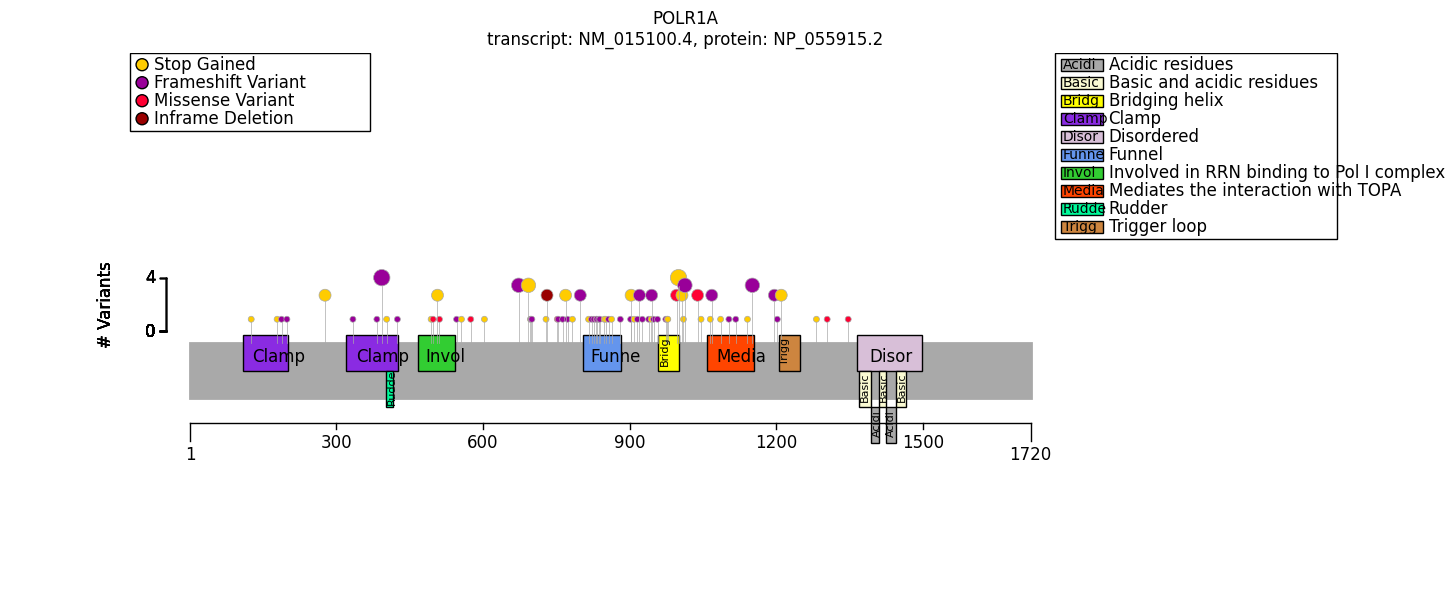

In [5]:
from gpsea.model.genome import GRCh38
from gpsea.model import ProteinMetadata
from gpsea.preprocessing import VVMultiCoordinateService, configure_default_protein_metadata_service
import matplotlib.pyplot as plt
from gpsea.view import ProteinVisualizer

txc_service = VVMultiCoordinateService(genome_build=GRCh38)
tx_coordinates = txc_service.fetch(mane_tx_id) 
pms = configure_default_protein_metadata_service()
#protein_meta = pms.annotate(mane_protein_id)

protein_meta = ProteinMetadata.from_uniprot_json(protein_id=mane_protein_id, 
                                                 label="POLR1A",
                                                 uniprot_json="O95602.json",
                                                 protein_length=1720)

polr1a_fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein_diagram(
    tx_coordinates,
    protein_meta,
    cohort,
    ax=ax,
)
polr1a_fig.tight_layout()

In [6]:
from gpsea.view import CohortVariantViewer

viewer = CohortVariantViewer(tx_id=mane_tx_id)
viewer.process(cohort)

Count,Variant key,HGVS,Overlapping Exons,Effects
4,1_151406034_151406034_G_A,c.3001C>T (p.Arg1001Ter),19,stop gained
4,1_151424958_151424960_CAT_C,c.1180_1181del (p.Met394ValfsTer9),8,frameshift
3,1_151408563_151408563_G_A,c.2080C>T (p.Arg694Ter),14,stop gained
3,1_151408734_151408735_CG_C,c.2020del (p.Arg674ValfsTer9),13,frameshift
3,1_151405577_151405579_CCT_C,c.3456_3457del (p.Glu1154ThrfsTer4),19,frameshift
3,SO:1000029_HGNC:18801_POGZ,SV involving POGZ (p.?),,chromosomal deletion
2,1_151406909_151406910_AC_A,c.2545+1del (-),-,splice donor
2,1_151423950_151423950_G_A,c.1522C>T (p.Arg508Ter),9,"stop gained, splice region"
2,1_151405917_151405917_C_T,c.3118G>A (p.Glu1040Lys),19,missense
2,1_151405404_151405404_G_A,c.3631C>T (p.Arg1211Ter),19,stop gained


In [7]:
from gpsea.view import ProteinVariantViewer
pvv = ProteinVariantViewer(protein_metadata=protein_meta, tx_id=mane_tx_id)
pvv.process(cohort)

Count,Name,Type,Coordinates,Variants
4,Clamp,Region,110 - 201,p.Gly201TrpfsTer114; p.Pro189GlnfsTer21; p.Gln180Ter; p.Arg127Ter
8,Clamp,Region,320 - 426,p.Arg385SerfsTer4; p.Tyr404Ter; p.Pro336GlnfsTer23; p.Glu427Ter; p.Met394ValfsTer9
1,Rudder,Region,403 - 416,p.Tyr404Ter
5,Involved in RRN3 binding to Pol I complex,Region,468 - 542,p.Cys499Phe; p.Arg508Ter; p.Arg495Ter; p.His512Asn
12,Funnel,Region,805 - 883,p.His840GlnfsTer23; p.His858GlnfsTer13; p.Ser839LeufsTer25; p.Asp828GlyfsTer36; p.Asn882LysfsTer14; p.Trp852Ter; p.His833Asn; p.Cys817Ter; p.Leu834TrpfsTer20; p.Thr824ProfsTer30; p.Arg864Ter; p.Gly849Ter
9,Bridging helix,Region,960 - 1001,p.Arg997Gln; p.Arg979PhefsTer3; p.Val975GlufsTer19; p.Arg997Ter; p.Arg979Ter; p.Arg1001Ter
10,Mediates the interaction with TOP2A,Region,1060 - 1155,p.Arg1087Ter; p.Arg1142Ter; p.Phe1104LeufsTer18; p.Leu1119CysfsTer3; p.Tyr1069Ter; p.Glu1154ThrfsTer4; p.Lys1066Ter
2,Trigger loop,Region,1207 - 1248,p.Arg1211Ter
0,Disordered,Region,1365 - 1498,
0,Basic and acidic residues,Compositional bias,1371 - 1394,


In [8]:
from gpsea.analysis.pcats import configure_hpo_term_analysis
from gpsea.analysis.clf import prepare_classifiers_for_terms_of_interest

analysis = configure_hpo_term_analysis(hpo)
pheno_clfs = prepare_classifiers_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

In [9]:
from gpsea.model import VariantEffect
from gpsea.analysis.predicate import variant_effect, protein_feature
from gpsea.analysis.clf import biallelic_classifier
from gpsea.view import MtcStatsViewer

is_missense = variant_effect(VariantEffect.MISSENSE_VARIANT, tx_id=mane_tx_id)

is_missense = protein_feature(feature_id="Mediates the interaction with TOP2A", protein_metadata=protein_meta)
missense_clf = biallelic_classifier(
    a_predicate=is_missense,
    b_predicate=~is_missense,
    a_label="missense",
    b_label="other",
    partitions=((0,),(2,1))
)
missense_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=missense_clf,
    pheno_clfs=pheno_clfs,
)


viewer = MtcStatsViewer()
viewer.process(missense_result)

Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.4,270
HMF08,Skipping general term,68


In [10]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo=hpo, result=missense_result)

Empty DataFrame
Columns: [(missense/missense, Count), (missense/missense, Percent), (other/other OR missense/other, Count), (other/other OR missense/other, Percent), (, p values)]
Index: []

In [11]:
from gpsea.view import summarize_hpo_analysis

report = summarize_hpo_analysis(hpo=hpo, result=result)
report

NameError: name 'result' is not defined